# VASSAR MINISCOPE PIPELINE CALIBRATION

Below is the interactive pipeline for setting up your parameters for Miniscope data analysis in Hopper. While the calibration process can be time consuming, it is important to carefully set the parameters at each ***PARAMETER CHECK*** in the pipeline. This is best accomplished with the aid of the visualizations in this interactive version of the pipeline. Further instructions and best practices are also given at each ***PARAMETER CHECK*** in the pipeline. Any cell that has no accompanying instructions should be run when it is reached and **should not be edited**. 

To run this notebook, first click on the 'Kernel' tab above and select 'Restart and Clear Output'. Then, run each cell one at a time with the 'Run' button above. Note that for more description of any of the steps in this pipeline, you can look at the annotation within the pipeline_noted.ipynb file.

# SETTING UP

## Load Modules

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"
import gc
import psutil
import numpy as np
import xarray as xr
import holoviews as hv
import matplotlib.pyplot as plt
import bokeh.plotting as bpl
import dask.array as da
import pandas as pd
import dask
import datashader as ds
import itertools as itt
import papermill as pm
import ast
import functools as fct
from holoviews.operation.datashader import datashade, regrid, dynspread
from datashader.colors import Sets1to3
from dask.diagnostics import ProgressBar
from IPython.core.display import display, HTML

## Set Path and Save Parameters

### *PARAMETER CHECK*

Here we define most of the navigation information for the pipeline including where the data is to be called from and how it will be stored. Here and in the normal pipeline there is only one variable that needs to be changed: *dpath*. *dpath* should refer to the directory in which the videos you are analyzing are stored in reference to your active directory. 

In [3]:
minian_path = "."
dpath = "./videos"
interactive = True
output_size = 100
param_save_minian = {
    'dpath': dpath,
    'fname': 'minian',
    'backend': 'zarr',
    'meta_dict': dict(session_id=-1, session=-2, animal=-3),
    'overwrite': True}

## Import Minian

In [5]:
%%capture
sys.path.append(minian_path)
from minian.utilities import load_params, load_videos, scale_varr, scale_varr_da, save_variable, open_minian, save_minian, handle_crash, get_optimal_chk, rechunk_like
from minian.preprocessing import remove_brightspot, gradient_norm, denoise, remove_background, stripe_correction
from minian.motion_correction import estimate_shifts, apply_shifts
from minian.initialization import seeds_init, gmm_refine, pnr_refine, intensity_refine, ks_refine, seeds_merge, initialize
from minian.cnmf import get_noise_fft, update_spatial, compute_trace, update_temporal, unit_merge, smooth_sig
from minian.visualization import VArrayViewer, CNMFViewer, generate_videos, visualize_preprocess, visualize_seeds, visualize_gmm_fit, visualize_spatial_update, visualize_temporal_update, roi_draw, write_video

## Module Initialization

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
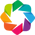

In [6]:
dpath = os.path.abspath(dpath)
if interactive:
    hv.notebook_extension('bokeh')
    pbar = ProgressBar(minimum=2)
    pbar.register()
else:
    hv.notebook_extension('matplotlib')

# PRE-PROCESSING

## Loading Videos and Visualization

### *PARAMETER CHECK*

These parameters describe how videos are found for the pipeline. While you shouldn't have to change anything here, it is important to see if the regex in the *pattern* variable matches the names of your videos. Furthermore, you can *downsample* (or compress) the videos by a factor of x in the call 'dict(frame=x)', but usually the default is fine. 

In [8]:
param_load_videos = {
    'pattern': 'msCam[0-9]+\.avi$',
    'dtype': np.uint8,
    'downsample': dict(frame=2),
    'downsample_strategy': 'subset'}

In [ ]:
%%time
varr = load_videos(dpath, **param_load_videos)
chk = get_optimal_chk(varr.astype(float), dim_grp=[('frame',), ('height', 'width')])

In [ ]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(varr, framerate=5, summary=None)
    display(vaviewer.show())

## Set ROI for Motion Correction

In [ ]:
if interactive:
    try:
        subset_mc = list(vaviewer.mask.values())[0]
    except IndexError:
        pass

## Subset Part of Video

### *PARAMETER CHECK*

If you would like to crop the videos, this is the place to do it. Here, there is no *subset* specified but you can crop in terms of frame (as exemplified in the comment below) as well as height and/or width. For example, to only use frames 100-500, set *subset* = dict(frame=slice(100,500)).

In [ ]:
subset = None #dict(frame=slice(0,None))

In [ ]:
varr_ref = varr.sel(subset)

## Glow Removal and Visualization

In [ ]:
%%time
varr_min = varr_ref.min('frame').compute()
varr_ref = varr_ref - varr_min

In [ ]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(
        [varr.rename('original'), varr_ref.rename('glow_removed')],
        framerate=5,
        summary=None,
        layout=True)
    display(vaviewer.show())

## Denoise

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_preprocess(varr_ref.isel(frame=0), denoise, method=['median'], ksize=[5, 7, 9, 11, 13, 15]))

### *PARAMETER CHECK*

To properly denoise the videos, we need to define the approximate size of the cells we are examining in the video. The variable *ksize* below serves that purpose. The interactive plot above is how we can determine *ksize*. In the interactive function above, you can define and test different values for ksize and see the differences in the resulting plots (note that ksize can only be odd numbers). You want ksize to be about the radius of the larger cells you are examining in pixels. To determine that radius, you can use the height and width axes to visualize how big each cell is.

![denoise](img/denoise.png)

The 'after' images of the denoise test should show contours similar to these. You do not want them to get much denser to ensure that there is not too much noise nor much sparser to ensure you don't miss components. Set the *ksize* value you determine below.

In [ ]:
param_denoise = {
    'method': 'median',
    'ksize': 7}

In [ ]:
varr_ref = denoise(varr_ref, **param_denoise)

## Background Removal

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_preprocess(varr_ref.isel(frame=0), remove_background, method=['tophat'], wnd=[10, 15, 20]))

### *PARAMETER CHECK*

Here we define how background noise is removed. The only variable that needs to be adjusted is *wnd* which should be set to the expected size of the largest cell's diameter (or for reference twice the value of *ksize* from above). Similar to the last parameter check, the interactive plot above can be used to test different values for *wnd*. 

![background](img/background.png)

If you follow the rule of thumb of having *wnd* set to be about twice *ksize* you'll end up with contours similar to this (perhaps a little more pronounced but not much). If you are not able to discern any possible cells within the contours, your *wnd* may be set too low while if the cells dominate the frame it may be set too high.

In [ ]:
param_background_removal = {
    'method': 'tophat',
    'wnd': 15}

In [ ]:
varr_ref = remove_background(varr_ref, **param_background_removal)

## Save Result

In [ ]:
%%time
varr_ref = varr_ref.chunk(chk)
varr_ref = save_minian(varr_ref.rename('org'), **param_save_minian)

# MOTION CORRECTION

## Load in from Disk

In [ ]:
varr_ref = open_minian(dpath,
                      fname=param_save_minian['fname'],
                      backend=param_save_minian['backend'])['org']

## Estimate Shifts

### *PARAMETER CHECK*

Here we define the parameters for motion correction. Generally, these parameters do not need to be altered but if you have a video set with lots of movement you can increase *max_sh* to increase how many pixels are trimmed during motion correction. You can also eye-test if the motion correction has been applied appropriately using the visualizations below.

In [ ]:
subset_mc = None
param_estimate_shift = {
    'dim': 'frame',
    'max_sh': 20}

In [ ]:
%%time
shifts = estimate_shifts(varr_ref.sel(subset_mc), **param_estimate_shift)

## Save Shifts

In [ ]:
%%time
shifts = shifts.chunk(dict(frame=chk['frame'])).rename('shifts')
shifts = save_minian(shifts, **param_save_minian)

## Visualization of Shifts

In [ ]:
%%opts Curve [frame_width=500, tools=['hover'], aspect=2]
hv.output(size=output_size)
if interactive:
    display(hv.NdOverlay(dict(width=hv.Curve(shifts.sel(variable='width')),
                              height=hv.Curve(shifts.sel(variable='height')))))

## Apply Shifts

In [ ]:
Y = apply_shifts(varr_ref, shifts)
Y = Y.fillna(0).astype(varr_ref.dtype)

## Visualization of Motion-Correction

In [ ]:
hv.output(size=output_size)
if interactive:
    vaviewer = VArrayViewer(
        [varr_ref.rename('before_mc'), Y.rename('after_mc')],
        framerate=5,
        summary=None,
        layout=True)
    display(vaviewer.show())

## Save Result

In [ ]:
%%time
Y = Y.chunk(chk)
Y = save_minian(Y.rename('Y'), **param_save_minian)

# INITIALIZATION

## Load in from Disk

In [ ]:
%%time
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])

In [ ]:
Y = minian['Y'].astype(np.float)
max_proj = Y.max('frame').compute()
Y_flt = Y.stack(spatial=['height', 'width'])

## Generating Over-Complete Set of Seeds

### *PARAMETER CHECK*

This function defines how seeds (local maxima of luminescence) are initially identified. While most of these variables will not need to be changed, they are described here. *wnd_size* is the number of frames in each subset and should not be larger than the total number of frames. *method* determines if the process is done sequentially (rolling) or randomly (random). *stp_size* is the size of the window in the rolling method. Note that in deep brain regions with sparser cells, increasing *wnd_size* and *stp_size* will make the process faster and cleaner. *nchunk* is the number of chunks used in the random method. *max_wnd* should be an estimate of the diameter of the largest cell you will detect (and should be a little larger than the *wnd* variable that was set in the background removal process - *max_wnd* is a threshold). *diff_thres* is a minimal difference across frames to determine if an object is a seed or artifact and is the most critical variable in this set. Generally, you can determine if it is too strict by the resulting output of the generated seeds below. If there are very few seeds in the frame, it is likely you need to lower the threshold. Because the threshold can only be changed in whole values, this may result in a large amount of seeds. However, it is better to overgenerate the seeds than to undergenerate them. 

![seeds](img/seeds.png)

Here is an example of three different *diff_thres* settings [1, 2, 3] on one data set. As you can see, the lowest setting yields almost no seeds which is not useful for the rest of the pipeline. The highest setting on the other hand generates a huge amount of seeds that may lead to several components that are not actually cells being identified. The middle setting here (2) is ideal as the seeds appear to be on the most luminscent parts of the frame without being too sparse (this example in fact is a little sparser than others you may run into, generally because *diff_thres* can only be set in whole values you will have to use your best judgement for which value is the best and adjust the rest of the pipeline accordingly). 

In [ ]:
param_seeds_init = { 
    'wnd_size': 2500, 
    'method': 'rolling', 
    'stp_size': 1500, 
    'nchunk': 100, 
    'max_wnd': 20, 
    'diff_thres': 2}

In [ ]:
%%time
seeds = seeds_init(Y, **param_seeds_init)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds)

## PNR Refine

In [ ]:
%%time
if interactive:
    noise_freq_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.8, 0.99]
    example_seeds = seeds.sample(6, axis='rows')
    example_trace = (Y_flt
                     .sel(spatial=[tuple(hw) for hw in example_seeds[['height', 'width']].values])
                     .assign_coords(spatial=np.arange(6))
                     .rename(dict(spatial='seed')))
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype='high')
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap({
            'signal': (hv.Dataset(trace_smth_low)
                       .to(hv.Curve, kdims=['frame'])
                       .opts(frame_width=300, aspect=2, ylabel='Signal (A.U.)')),
            'noise': (hv.Dataset(trace_smth_high)
                      .to(hv.Curve, kdims=['frame'])
                      .opts(frame_width=300, aspect=2, ylabel='Signal (A.U.)'))
        }, kdims='trace').collate()
        smooth_dict[freq] = hv_trace

In [ ]:
hv.output(size=output_size)
if interactive:
    hv_res = (hv.HoloMap(smooth_dict, kdims=['noise_freq']).collate().opts(aspect=2)
              .overlay('trace').layout('seed').cols(3))
    display(hv_res)

### *PARAMETER CHECK*

The plot above tests different noise frequencies to best discriminate signal from noise. *noise_freq* is the only parameter you will need to change from the set below. Generally, we want to make sure that the signal and noise are as separate as possible while also ensuring that the signal bands don't get too thick.

![signals](img/signal.png)

Here we can see an example of three different *noise_freq* settings [0.05, 0.3, 0.8] on the same dataset. 0.05 is clearly too low as the signal is easily muddled with the noise and does not show a very descriptive plot of the signal regardless. On the other hand, 0.8 shows a very noisy signal with a dramatically changed noise plot (this is an example of the signal band being too thick). Something more like the middle graph (0.3) is more idal for the pipeline. 

In [ ]:
param_pnr_refine = {
    'noise_freq': 0.3,
    'thres': 1,
    'med_wnd': None}

In [ ]:
seeds, pnr, gmm = pnr_refine(Y_flt, seeds.copy(), **param_pnr_refine)

In [ ]:
if gmm:
    display(visualize_gmm_fit(pnr, gmm, 100))

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, 'mask_pnr')

## ks Refine

### *PARAMETER CHECK*

*sig* defines the significance value of a Kolmogorov-Smirnov test that takes the remaining seeds and elminates those with a normal distribution of flourescence (as it should be somewhat bimodal). Generally, you shouldn't need to change this, but it is important to know regardless. Additionally, note that this step may remove too many seeds if the videos are very short and can be skipped based on your discretion.  

In [ ]:
param_ks_refine = {
    'sig': 0.05}

In [ ]:
%%time
seeds = ks_refine(Y_flt, seeds[seeds['mask_pnr']], **param_ks_refine)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds, 'mask_ks')

## Merge Seeds

### *PARAMETER CHECK*

This set of parameters defines how initial seeds are merged together into spatial objects based on spatial and temporal correlation. *thres_dist* is the threshold for Euclidean distance between pairs of seeds (measured in pixels, generally whatever you entered for *ksize* in the denoise parameters should work). 'thres_corr' is the threshold for Pearson correlations (which measures temporal correlation) between pairs of seeds and should be set relatively high. *noise_freq* should be the same as defined in param_pnr_refine.

In [ ]:
param_seeds_merge = {
    'thres_dist': 7,
    'thres_corr': 0.7,
    'noise_freq': 0.3}

In [ ]:
%%time
seeds_final = seeds[seeds['mask_ks']].reset_index(drop=True)
seeds_mrg = seeds_merge(Y_flt, seeds_final, **param_seeds_merge)

In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds_mrg, 'mask_mrg')

## Initialize Spatial and Temporal Matrices from Seeds

### *PARAMETER CHECK*

This set of parameters defines how pixels are included or excluded from initial spatial footprints created around the found seeds. *wnd* determines the window size for calculating correlation with other pixels for efficiency and therefore is the maximum size of a footprint in this initial step. It should be set to be the same as the *wnd* variable from the background removal parameters. *thres_corr* determines which pixels are not part of the cell to make sure that there isn't temporal noise in the footprint and also should be kept relatively high. *noise_freq* should again be the same as previous functions.

In [ ]:
param_initialize = {
    'thres_corr': 0.7,
    'wnd': 15,
    'noise_freq': 0.3}

In [ ]:
%%time
A, C, b, f = initialize(Y, seeds_mrg[seeds_mrg['mask_mrg']], **param_initialize)

In [ ]:
im_opts = dict(frame_width=500, aspect=A.sizes['width']/A.sizes['height'], cmap='Viridis', colorbar=True)
cr_opts = dict(frame_width=750, aspect=1.5*A.sizes['width']/A.sizes['height'])
(regrid(hv.Image(A.sum('unit_id').rename('A').compute(), kdims=['width', 'height'])).opts(**im_opts)
 + regrid(hv.Image(C.rename('C').compute(), kdims=['frame', 'unit_id'])).opts(cmap='viridis', colorbar=True, **cr_opts)
  + regrid(hv.Image(b.rename('b').compute(), kdims=['width', 'height'])).opts(**im_opts)
 + datashade(hv.Curve(f.rename('f').compute(), kdims=['frame']), min_alpha=200).opts(**cr_opts)
).cols(2)

## Save Results

In [ ]:
%%time
A = save_minian(A.rename('A_init').rename(unit_id='unit_id_init'), **param_save_minian)
C = save_minian(C.rename('C_init').rename(unit_id='unit_id_init'), **param_save_minian)
b = save_minian(b.rename('b_init'), **param_save_minian)
f = save_minian(f.rename('f_init'), **param_save_minian)

# CNMF

## Loading Data

In [ ]:
%%time
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])
Y = minian['Y'].astype(np.float)
A_init = minian['A_init'].rename(unit_id_init='unit_id')
C_init = minian['C_init'].rename(unit_id_init='unit_id')
b_init = minian['b_init']
f_init = minian['f_init']

## Estimate Spatial Noise

### *PARAMETER CHECK*

The *noise_range* defined below is range for each pixel that needs to be explored/pre-defined before executing any of the CNMF. The upper limit should always be 0.5 but the lower limit should generally be in the range of 0.05 - 0.1 (for the most part the default will be fine).  

In [ ]:
param_get_noise = {
    'noise_range': (0.1, 0.5),
    'noise_method': 'logmexp'}

In [ ]:
%%time
sn_spatial = get_noise_fft(Y, **param_get_noise).persist()

## Test Parameters for First Spatial Update

### *PARAMETER CHECK*

Provides the parameters for the spatial update. 'd1_wnd' determines the window size in which units are updated, should be set to the diameter of the largest cell (which has been previously specified in other parameters). The other critical parameter here is *sparse_penal* which should optimizee the binary spatial matrix. While that sounds kind of vague, this is another case in which the visualizations are critical. Below is an interactive function that tests a list of sparse penalties (*sprs_ls*). 

![spatial](img/spatial.png)

Here again the left panel is too liberal and the right is too conservative in terms of the *sparse_penal*. The left takes in too many pixels and results in odd shapes that are not representative of the actual cell in the video. On the right, the penalty is so high that real cells are removed entirely from the analysis. Thus, something like the image in the middle is ideal, where the shapes are those of cells but where no cell is eliminated by the analysis. 

In [ ]:
 param_first_spatial = {
    'dl_wnd': 15,
    'sparse_penal': 0.3,
    'update_background': True,
    'normalize': True,
    'zero_thres': 'eps'}

In [ ]:
if interactive:
    units = np.random.choice(A_init.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_init.sel(unit_id=units).persist()
    C_sub = C_init.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.05, 0.3, 0.9]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_sub, b_init, C_sub, f_init,
            sn_spatial, dl_wnd=param_first_spatial['dl_wnd'], sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = cur_C.compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## First Spatial Update

In [ ]:
%%time
A_spatial, b_spatial, C_spatial, f_spatial = update_spatial(
    Y, A_init, b_init, C_init, f_init, sn_spatial, **param_first_spatial)

In [ ]:
hv.output(size=output_size)
opts = dict(plot=dict(height=A_init.sizes['height'], width=A_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
(regrid(hv.Image(A_init.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Initial")
+ regrid(hv.Image((A_init.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Initial")
+ regrid(hv.Image(A_spatial.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_spatial > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
opts_cr = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['height'] * 2))
(regrid(hv.Image(b_init.compute(), kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Initial')
 + datashade(hv.Curve(f_init.compute(), kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Initial')
 + regrid(hv.Image(b_spatial.compute(), kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial.compute(), kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
).cols(2)

## Test Parameters for First Temporal Update

In [ ]:
if interactive:
    units = np.random.choice(A_spatial.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_spatial.sel(unit_id=units).persist()
    C_sub = C_spatial.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1, 2]
    sprs_ls = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
    add_ls = [20, 40, 60]
    noise_ls = [0.1, 0.2]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = compute_trace(Y, A_sub, b_spatial, C_sub, f_spatial).persist()
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
            .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_sub, b_spatial, C_sub, f_spatial, sn_spatial, YrA=YrA,
            sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise)
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(), cur_C.compute(), cur_S.compute(), cur_g.compute(), cur_sig.compute(), A_sub.compute())
    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=['p', 'sparse penalty', 'additional lag', 'noise frequency'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## First Temporal Update

### *PARAMETER CHECK*

The temporal updates have several updates which will be briefly covered here. Many of these parameters will remain the same as the defaults, but it is still important to think about them in relation to your data.   
- *sparse_penal* is the most important parameter here and should be tweaked to adjust the balance between fidelity and sparsity. This can be done based on the outputs of the interactive plots directly above (note that *sparse_penal* is the second slider).  
- *noise_freq* is the threshold for determining noise in the 'update_temporal' function and should also be determined using the plots above (note that *noise_freq* is the fourth slider).  

![temporal](img/first_tem_param.png)

The inferred spiking signal (shown here in green) should generally have spikes that match peaks in the raw signal (shown in red). So, on the left the signal is too noisy as there are lots of little spikes that may not be representative of anything in the raw signal. Conversely, on the right the drawback is that there are no inferred spikes where there are clear spikes in the raw signal. So, an image like that in the middle is ideal for setting this parameter.

Other important parameters include:  
- *p* should be set to 2 if the calcium transients have an observable rise time (evident and should be set to 1 if the rise-time is faster than the sampling rate. (Note that *p* is the top slider).
- *add_lag* should be set to the approximate decay time of the signal in frames (which you can also determine from the interactive plots above).    

The rest of the parameters listed below likely do not need to be changed:  
- *use_spatial* should be left alone, as turning it to TRUE is very computationally demanding.  
- *jac_thres* determines what proportion of a cell's spatial footprint needs to be covered to be considered  "overlapping": the default is good for data that is compact in cells.  
- *use_smooth* determines if noise is accounted for in the first place.  
- *max_iters* determines how many times the compute tries to solve a small issue before throwing up a warning while - - *scs_fallback* controls whether an scs attempt should be made (you shouldn't need to tweak these).  
- *zero_thres* is set to eliminate small values.  

In [ ]:
param_first_temporal = {
    'noise_freq': 0.1,
    'sparse_penal': 0.35,
    'p': 1,
    'add_lag': 30,
    'use_spatial': False,
    'jac_thres': 0.2,
    'zero_thres': 1e-8,
    'max_iters': 200,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}

In [ ]:
%%time
YrA, C_temporal, S_temporal, B_temporal, C0_temporal, sig_temporal, g_temporal, scale = update_temporal(
    Y, A_spatial, b_spatial, C_spatial, f_spatial, sn_spatial, **param_first_temporal)
A_temporal = A_spatial.sel(unit_id = C_temporal.coords['unit_id'])

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(C_init.rename('ci').compute(), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace Initial")
 + hv.Div('')
 + regrid(hv.Image(C_temporal.rename('c1').compute(), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update")
 + regrid(hv.Image(S_temporal.rename('s1').compute(), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update")
).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial.sizes['height'], A_spatial.sizes['width']
    im_opts = dict(aspect=w/h, frame_width=500, cmap='Viridis')
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = list(set(A_spatial.coords['unit_id'].values) - set(A_temporal.coords['unit_id'].values))
    bad_units.sort()
    if len(bad_units)>0:
        hv_res = (hv.NdLayout({
            "Spatial Footprint": regrid(hv.Dataset(A_spatial.sel(unit_id=bad_units).compute().rename('A'))
                                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts),
            "Spatial Footprints of Accepted Units": regrid(hv.Image(A_temporal.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**im_opts)
        })
                  + datashade(hv.Dataset(YrA.sel(unit_id=bad_units).compute().rename('raw'))
                              .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_temporal_update(YrA.compute(), C_temporal.compute(), S_temporal.compute(), g_temporal.compute(), sig_temporal.compute(), A_temporal.compute()))

## Merge Units

### *PARAMETER CHECK*

This step merges resulting components from the first spatial and first temporal updates if they are closely correlated. *thres_corr* is the pearson threshold to determine which units belong in the same cell. Generally, the default value of 0.8 is fine but this can be adjusted if it seems too conservative. 

In [ ]:
param_first_merge = {
    'thres_corr': 0.8}

In [ ]:
%%time
A_mrg, sig_mrg, add_list = unit_merge(A_temporal, sig_temporal, [S_temporal, C_temporal], **param_first_merge)
S_mrg, C_mrg = add_list[:]

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(sig_temporal.compute().rename('c1'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals Before Merge").opts(**opts_im) +
regrid(hv.Image(sig_mrg.compute().rename('c2'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals After Merge").opts(**opts_im))

## Test Parameters for Second Spatial Update

### *PARAMETER CHECK*

The parameters of the second spatial update are the same as the first. *d1_wnd* should be exactly the same as in the first update, and the interactive plots can again be used to determine an appropriate *sparse_penal* (note that it will likely be significantly lower than the first).  

In [ ]:
param_second_spatial = {
    'dl_wnd': 15,
    'sparse_penal': 0.025,
    'update_background': True,
    'normalize': True,
    'zero_thres': 'eps'}

In [ ]:
if interactive:
    units = np.random.choice(A_mrg.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_mrg.sel(unit_id=units).persist()
    sig_sub = sig_mrg.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.01, 0.02, 0.03, 0.04]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_sub, b_init, sig_sub, f_init,
            sn_spatial, dl_wnd=param_second_spatial['dl_wnd'], sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = cur_C.compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## Second Spatial Update

In [ ]:
%%time
A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2 = update_spatial(
    Y, A_mrg, b_spatial, sig_mrg, f_spatial, sn_spatial, **param_second_spatial)

In [ ]:
hv.output(size=output_size)
opts = dict(aspect=A_spatial_it2.sizes['width']/A_spatial_it2.sizes['height'], frame_width=500, colorbar=True, cmap='Viridis')
(regrid(hv.Image(A_mrg.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_mrg.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")
+ regrid(hv.Image(A_spatial_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Second Update")
+ regrid(hv.Image((A_spatial_it2 > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Second Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(aspect=b_spatial_it2.sizes['width'] / b_spatial_it2.sizes['height'], frame_width=500, colorbar=True, cmap='Viridis')
opts_cr = dict(aspect=2, frame_height=int(500 * b_spatial_it2.sizes['height'] / b_spatial_it2.sizes['width']))
(regrid(hv.Image(b_spatial.compute(), kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial.compute(), kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
 + regrid(hv.Image(b_spatial_it2.compute(), kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Second Update')
 + datashade(hv.Curve(f_spatial_it2.compute(), kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Second Update')
).cols(2)

## Test Parameters for Second Temporal Update

In [ ]:
if interactive:
    units = np.random.choice(A_spatial_it2.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_spatial_it2.sel(unit_id=units).persist()
    C_sub = C_spatial_it2.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    add_ls = [30]
    noise_ls = [0.1]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = compute_trace(Y, A_sub, b_spatial, C_sub, f_spatial).persist()
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
              .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_sub, b_spatial, C_sub, f_spatial, sn_spatial, YrA=YrA,
            sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise)
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA.compute(), cur_C.compute(), cur_S.compute(), cur_g.compute(), cur_sig.compute(), A_sub.compute())
    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=['p', 'sparse penalty', 'additional lag', 'noise frequency'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## Second Temporal Update

### *PARAMETER CHECK*

Again, this is the same parameter set as the first update. This time, *noise_freq*, *p*, and *add_lag* should be kept the same as they were in the first update. The interactive plots above should be used just to adjust *sparse_penal* to best fit the inferred spiking pattern in the remaining components. 

In [ ]:
param_second_temporal = {
    'noise_freq': 0.1,
    'sparse_penal': 0.25,
    'p': 1,
    'add_lag': 30,
    'use_spatial': False,
    'jac_thres': 0.2,
    'zero_thres': 1e-8,
    'max_iters': 500,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}

In [ ]:
%%time
YrA, C_temporal_it2, S_temporal_it2, B_temporal_it2, C0_temporal_it2, sig_temporal_it2, g_temporal_it2, scale_temporal_it2 = update_temporal(
    Y, A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2, sn_spatial, **param_second_temporal)
A_temporal_it2 = A_spatial_it2.sel(unit_id=C_temporal_it2.coords['unit_id'])
g_temporal_it2 = g_temporal_it2.sel(unit_id=C_temporal_it2.coords['unit_id'])
A_temporal_it2 = rechunk_like(A_temporal_it2, A_spatial_it2)
g_temporal_it2 = rechunk_like(g_temporal_it2, C_temporal_it2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(C_mrg.rename('c1').compute(), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update")
 + regrid(hv.Image(S_mrg.rename('s1').compute(), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update")
 + regrid(hv.Image(C_temporal_it2.rename('c2').rename(unit_id='unit_id_it2').compute(), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Temporal Trace Second Update")
 + regrid(hv.Image(S_temporal_it2.rename('s2').rename(unit_id='unit_id_it2').compute(), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Spikes Second Update")).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial_it2.sizes['height'], A_spatial_it2.sizes['width']
    im_opts = dict(aspect=w/h, frame_width=500, cmap='Viridis')
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = list(set(A_spatial_it2.coords['unit_id'].values) - set(A_temporal_it2.coords['unit_id'].values))
    bad_units.sort()
    if len(bad_units)>0:
        hv_res = (hv.NdLayout({
            "Spatial Footprin": regrid(hv.Dataset(A_spatial_it2.sel(unit_id=bad_units).compute().rename('A'))
                                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts),
            "Spatial Footprints of Accepted Units": regrid(hv.Image(A_temporal_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**im_opts)
        })
                  + datashade(hv.Dataset(YrA.sel(unit_id=bad_units).compute().rename('raw'))
                              .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_temporal_update(YrA.compute(), C_temporal_it2.compute(), S_temporal_it2.compute(), g_temporal_it2.compute(), sig_temporal_it2.compute(), A_temporal_it2.compute()))

## Save Results

In [ ]:
%%time
A_temporal_it2 = save_minian(A_temporal_it2.rename('A'), **param_save_minian)
C_temporal_it2 = save_minian(C_temporal_it2.rename('C'), **param_save_minian)
S_temporal_it2 = save_minian(S_temporal_it2.rename('S'), **param_save_minian)
g_temporal_it2 = save_minian(g_temporal_it2.rename('g'), **param_save_minian)
C0_temporal_it2 = save_minian(C0_temporal_it2.rename('C0'), **param_save_minian)
B_temporal_it2 = save_minian(B_temporal_it2.rename('bl'), **param_save_minian)
b_spatial_it2 = save_minian(b_spatial_it2.rename('b'), **param_save_minian)
f_spatial_it2 = save_minian(f_spatial_it2.rename('f'), **param_save_minian)

## Visualization

Here is where you can examine the results of the pipeline! Note that while in the interactive notebook you have the ability to manually remove or join resulting components, you will not have this power in the batch version of the pipeline. Therefore, the following output should be satisfying as is. 

In [26]:
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])
varr = load_videos(dpath, **param_load_videos)
chk = get_optimal_chk(varr.astype(float), dim_grp=[('frame',), ('height', 'width')])
varr = varr.chunk(dict(frame=chk['frame']))

loading 1 videos in folder /Users/eden/minian/videos


/Users/eden/minian/minian/utilities.py:832: UserWarning: estimated memory limit is smaller than 0. Using 64MiB chunksize instead. Make sure you have enough memory or manually set mem_limit
  warnings.warn(


In [27]:
%%time
if interactive:
    cnmfviewer = CNMFViewer(minian)

computing centroids
[########################################] | 100% Completed |  0.3s
computing sum projection
[########################################] | 100% Completed |  0.2s
CPU times: user 12.7 s, sys: 7.2 s, total: 19.9 s
Wall time: 16.5 s


In [28]:
hv.output(size=output_size)
if interactive:
    display(cnmfviewer.show())

Column
    [0] HoloViews(Layout)
    [1] Row
        [0] Column
            [0] Row
                [0] WidgetBox(width=150)
                    [0] Button(button_type='primary', height=30, name='Refresh', sizing_mode='fixed', width=120)
                    [1] Button(button_type='danger', height=30, name='Load Data', sizing_mode='fixed', width=120)
                [1] WidgetBox(width=150)
                    [0] Checkbox(height=15, name='UseAC', sizing_mode='fixed', value=True, width=120)
            [1] Column
                [0] Row
                    [0] WidgetBox(width=150)
                        [0] Checkbox(height=10, name='Normalize', sizing_mode='fixed', width=120)
                        [1] Checkbox(height=10, name='ShowC', sizing_mode='fixed', value=True, width=120)
                        [2] Checkbox(height=10, name='ShowS', sizing_mode='fixed', value=True, width=120)
                        [3] Select(height=30, options=OrderedDict([('group0', ...]), sizing_mode='fixed', value=[80, 62, 52, 51, 48], width=120)
                    [1] WidgetBox(width=150)
                        [0] Button(button_type='primary', height=30, name='Previous Group', sizing_mode='fixed', width=120)
                        [1] Button(button_type='primary', height=30, name='Next Group', sizing_mode='fixed', width=120)
                [1] Player(end=12999, interval=10, width=280)
        [1] HoloViews(GridSpace)
        [2] Column
            [0] WidgetBox(width=200)
                [0] Button(button_type='primary', name='Discard Selected', width=200)
                [1] Button(button_type='primary', name='Merge Selected', width=200)
            [1] Row
                [0] WidgetBox(width=100)
                    [0] Checkbox(height=50, name='Unit ID: 80', sizing_mode='fixed', width=100)
                    [1] Checkbox(height=50, name='Unit ID: 62', sizing_mode='fixed', width=100)
                    [2] Checkbox(height=50, name='Unit ID: 52', sizing_mode='fixed', width=100)
                    [3] Checkbox(height=50, name='Unit ID: 51', sizing_mode='fixed', width=100)
                    [4] Checkbox(height=50, name='Unit ID: 48', sizing_mode='fixed', width=100)
                [1] WidgetBox(width=100)
                    [0] Select(height=50, name='Unit Label', options=[80, 62, 52, 51, ...], sizing_mode='fixed', value=80, width=100)
                    [1] Select(height=50, name='Unit Label', options=[80, 62, 52, 51, ...], sizing_mode='fixed', value=62, width=100)
                    [2] Select(height=50, name='Unit Label', options=[80, 62, 52, 51, ...], sizing_mode='fixed', value=52, width=100)
                    [3] Select(height=50, name='Unit Label', options=[80, 62, 52, 51, ...], sizing_mode='fixed', value=51, width=100)
                    [4] Select(height=50, name='Unit Label', options=[80, 62, 52, 51, ...], sizing_mode='fixed', value=48, width=100)

In [16]:
if interactive:
    save_minian(cnmfviewer.unit_labels, **param_save_minian)